In [17]:
from __future__ import print_function, division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"  #  GPU(s) to be used

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt 
import time

import copy

plt.ion()   # interactive mode

In [18]:
#for other model

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.3),
#         transforms.RandomVerticalFlip(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [19]:

data_dir = '/home/abhishek/usgwork/US_samples/level_1a/data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
image_datasets['train'].classes

['Abnormal', 'Normal']

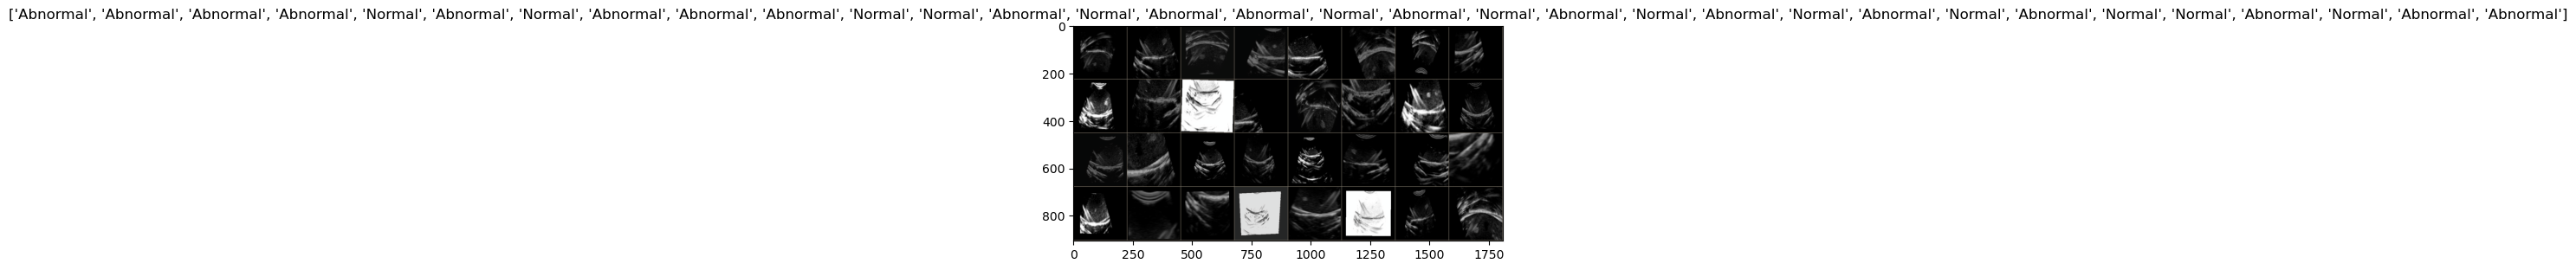

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    coll_train_loss = []
    coll_train_acc = []
    coll_val_loss = []
    coll_val_acc = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #inputs = inputs.squeeze(1) 
                    outputs = model(inputs)

                    #outputs = outputs.squeeze(0)                # extra thing added may remove if not using
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                coll_train_loss.append(epoch_loss)
                coll_train_acc.append(epoch_acc)
            if phase == 'val':
                coll_val_loss.append(epoch_loss)
                coll_val_acc.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, coll_train_loss,coll_train_acc,coll_val_loss,coll_val_acc

In [23]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            print(inputs.shape)
            outputs = model(inputs)
            print(outputs.shape)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [24]:
from torchvision import models
from timm import create_model


#Swin Transformer

model_ft = create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=2)
model_ft = nn.DataParallel(model_ft)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.01)


In [25]:
model_ft,coll_train_loss,coll_train_acc,coll_val_loss,coll_val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=150)

Epoch 0/149
----------
train Loss: 0.4423 Acc: 0.7895
val Loss: 0.2557 Acc: 0.8870

Epoch 1/149
----------
train Loss: 0.2985 Acc: 0.8708
val Loss: 0.1900 Acc: 0.9036

Epoch 2/149
----------
train Loss: 0.2515 Acc: 0.8900
val Loss: 0.2536 Acc: 0.9017

Epoch 3/149
----------
train Loss: 0.2317 Acc: 0.8954
val Loss: 0.1801 Acc: 0.9231

Epoch 4/149
----------
train Loss: 0.2099 Acc: 0.9102
val Loss: 0.1494 Acc: 0.9348

Epoch 5/149
----------
train Loss: 0.1908 Acc: 0.9184
val Loss: 0.1313 Acc: 0.9435

Epoch 6/149
----------
train Loss: 0.1802 Acc: 0.9156
val Loss: 0.1385 Acc: 0.9406

Epoch 7/149
----------
train Loss: 0.1683 Acc: 0.9256
val Loss: 0.1541 Acc: 0.9416

Epoch 8/149
----------
train Loss: 0.1825 Acc: 0.9184
val Loss: 0.1884 Acc: 0.9279

Epoch 9/149
----------
train Loss: 0.1504 Acc: 0.9342
val Loss: 0.1358 Acc: 0.9455

Epoch 10/149
----------
train Loss: 0.1520 Acc: 0.9382
val Loss: 0.0981 Acc: 0.9572

Epoch 11/149
----------
train Loss: 0.1527 Acc: 0.9329
val Loss: 0.0830 Acc

torch.Size([32, 3, 224, 224])
torch.Size([32, 2])


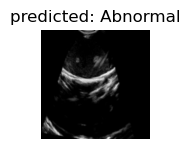

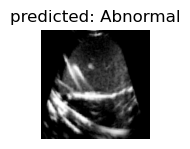

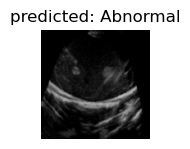

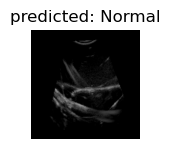

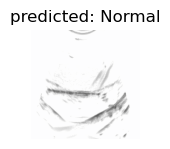

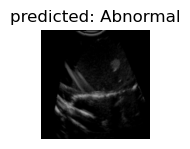

In [26]:
visualize_model(model_ft)

In [27]:
PATH='/data/abhishek/New_model_and_csv/swin_gimbal_Net_32b.pth'
torch.save(model_ft,PATH)
num_epochs=150

# Custom file path and name
model_save_path = '/data/abhishek/New_model_and_csv/swin_gimabl_Net_32b_stat.pth'

# Save the model's state_dict
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model_ft.state_dict(),
    'optimizer_state_dict': optimizer_ft.state_dict(),
    'loss': coll_train_loss,
}, model_save_path)


In [28]:
from itertools import zip_longest
import csv
lists = [coll_train_loss,coll_train_acc,coll_val_loss,coll_val_acc]
export_data = zip_longest(*lists, fillvalue='')
with open(r'/data/abhishek/New_model_and_csv/swin_gimbal_Net_32b'+'.csv','w',encoding="ISO-8859-1", newline ='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(("coll_train_loss","coll_train_acc","coll_val_loss","coll_val_acc"))
    wr.writerows(export_data)
myfile.close()